In [1]:
import lgbm_pipeline.feature_load as loader
import lgbm_pipeline.feature_extraction as extractor

from tqdm import tqdm
import polars as pl
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer, RocCurveDisplay, ConfusionMatrixDisplay, classification_report
import seaborn as sns
import xgboost as xgb

VITALS = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
LABS = [
    'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
    'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
    'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium', 'Bilirubin_total',
    'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC', 'Fibrinogen', 'Platelets'
]
DEMOGRAPHICS = ['Age', 'Gender']
DROPS = ['Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']
OUTCOME = 'SepsisLabel'

FEATURES = VITALS + LABS + DEMOGRAPHICS

In [2]:
patients: list[pl.DataFrame] = loader.load_data("../training_set?/*.psv", max_files=None)

Loading files: 100%|██████████| 40336/40336 [00:42<00:00, 939.63it/s]


In [6]:
# Get the correlation matrix
corr_matrix = pl.concat(patients).to_pandas().corr()

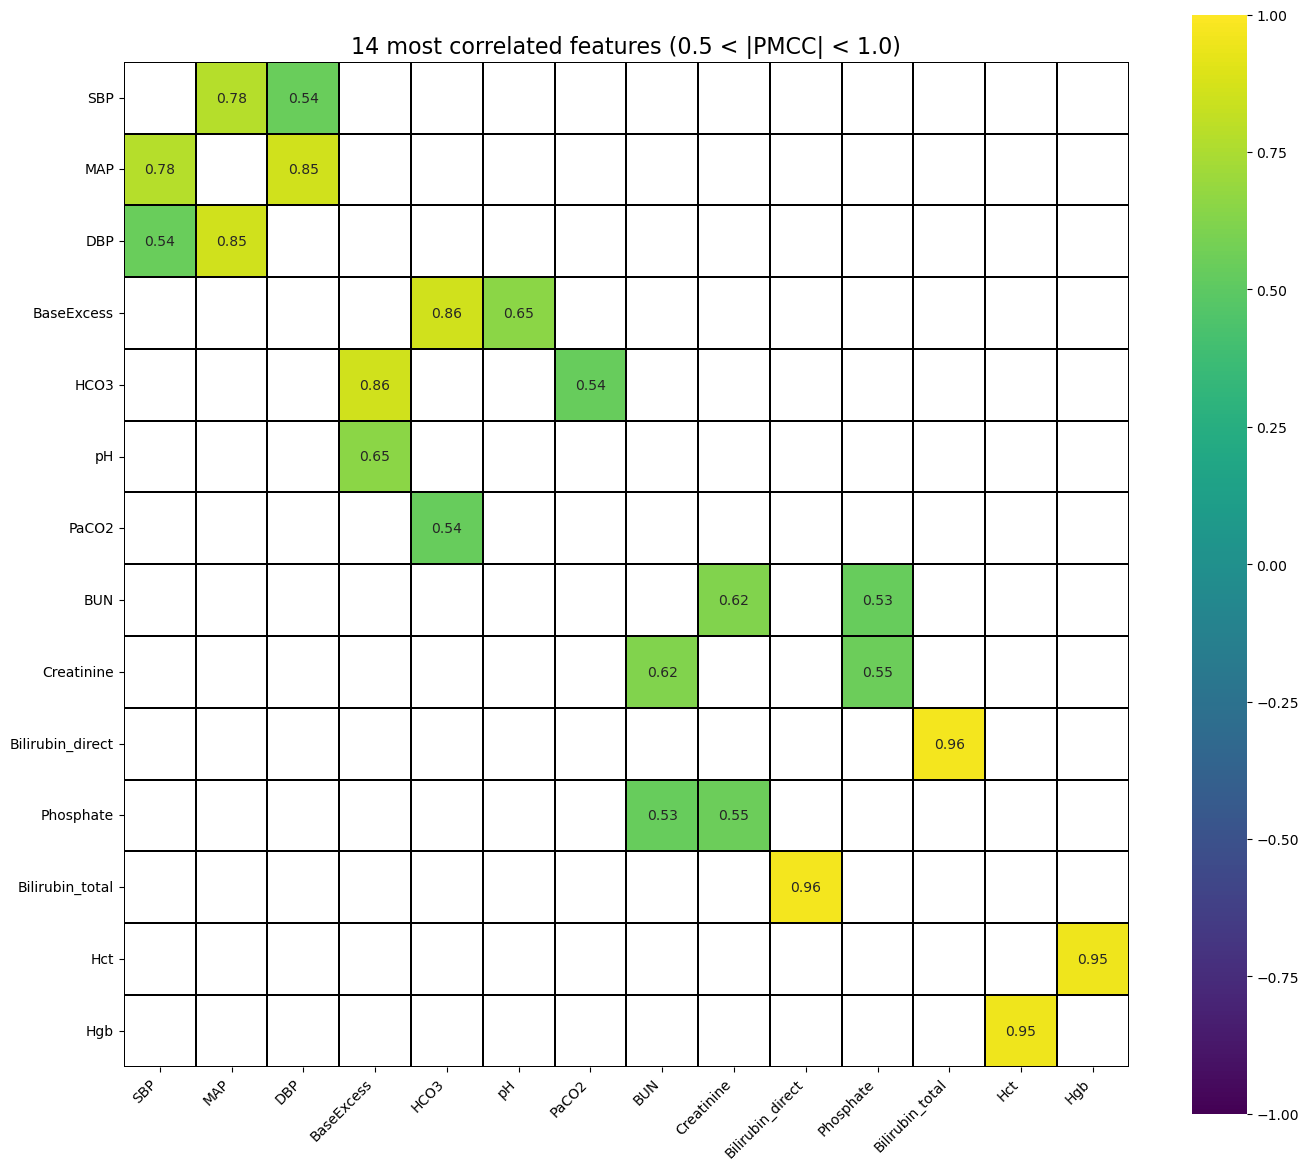

In [33]:
# Create a mask for correlations with abs value <= 0.5 or exactly 1.0
mask = (abs(corr_matrix) <= 0.5) | (abs(corr_matrix) >= 0.99999)
# Apply the mask (replacing filtered values with NaN)
filtered_corr = corr_matrix.mask(mask)
# Find columns that have at least one value in our desired range
has_correlations = (~filtered_corr.isnull()).sum() > 0
columns_to_keep = filtered_corr.columns[has_correlations]
# Keep only those columns/rows in the correlation matrix
reduced_corr = filtered_corr.loc[columns_to_keep, columns_to_keep]

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 12))
sns.heatmap(
    reduced_corr,
    xticklabels=True,
    yticklabels=True,
    cmap="viridis",
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    annot=True,
    #mask=np.triu(reduced_corr), # keep lower triangle only
    linecolor="black",
    linewidths=0.25,
)

import os
plt.title(f'{len(columns_to_keep)} most correlated features (0.5 < |PMCC| < 1.0)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f"{os.getcwd()}/../plots/correlation_matrix.svg", format="svg")
plt.show()

In [ ]:
sepsis_patients: list[pl.DataFrame] = []
non_sepsis_patients: list[pl.DataFrame] = []

for patient in tqdm(patients, "Splitting sepsis/non-sepsis patients"):
	if patient["SepsisLabel"].any():
		sepsis_patients.append(patient)
	else:
		non_sepsis_patients.append(patient)

In [ ]:
train_sepsis_patients, test_sepsis_patients = train_test_split(sepsis_patients, random_state=42)
train_non_sepsis_patients, test_non_sepsis_patients = train_test_split(non_sepsis_patients, random_state=42)

In [ ]:
ratio: float = len(train_non_sepsis_patients) / len(train_sepsis_patients)
print(f"Ratio: {ratio}")

train_patients: list[pl.DataFrame] = train_sepsis_patients + train_non_sepsis_patients
test_patients: list[pl.DataFrame] = test_sepsis_patients + test_non_sepsis_patients

print(f"Number of sepsis patients in training set: {len(train_sepsis_patients)}")
print(f"Number of non-sepsis patients in training set: {len(train_non_sepsis_patients)}")
print(f"Number of patients in training set: {len(train_patients)}\n")
print(f"Number of sepsis patients in testing set: {len(test_sepsis_patients)}")
print(f"Number of non-sepsis patients in testing set: {len(test_non_sepsis_patients)}")
print(f"Number of patients in testing set: {len(test_patients)}")

In [ ]:
all_patients = pl.concat(train_patients + test_patients)
sns.heatmap(all_patients.corr(), xticklabels=True, yticklabels=True)

In [ ]:
train_patients_forward = extractor.fill(train_patients, extractor.FillMethod.FORWARD)
train_patients_backward = extractor.fill(train_patients, extractor.FillMethod.BACKWARD)
train_patients_linear = extractor.fill(train_patients, extractor.FillMethod.LINEAR)

In [ ]:
fill_to_list: dict[extractor.FillMethod, list[pl.DataFrame]] = {
	extractor.FillMethod.FORWARD : train_patients_forward,
	extractor.FillMethod.BACKWARD: train_patients_backward,
	extractor.FillMethod.LINEAR  : train_patients_linear,
    }

fill_to_concat: dict[extractor.FillMethod, pl.DataFrame] = {
	extractor.FillMethod.FORWARD : pl.concat(train_patients_forward, how="vertical"),
	extractor.FillMethod.BACKWARD: pl.concat(train_patients_backward, how="vertical"),
	extractor.FillMethod.LINEAR  : pl.concat(train_patients_linear, how="vertical"),
    }

fill_to_corr: dict[extractor.FillMethod, pl.DataFrame] = {
	extractor.FillMethod.FORWARD : fill_to_concat[extractor.FillMethod.FORWARD].corr(),
	extractor.FillMethod.BACKWARD: fill_to_concat[extractor.FillMethod.BACKWARD].corr(),
	extractor.FillMethod.LINEAR  : fill_to_concat[extractor.FillMethod.LINEAR].corr(),
    }

#print(len(method_to_all_patients[extractor.FillMethod.FORWARD]))
#(pl.concat(fill_method_to_train_patients[extractor.FillMethod.BACKWARD])).tail(10)
fill_to_list[extractor.FillMethod.FORWARD][0].head(100)

In [ ]:

fill_methods_to_use: dict[str, extractor.FillMethod] = extractor.best_fill_method_for_feature(fill_to_corr,FEATURES)
train_patients_mixed: list[pl.DataFrame] = extractor.mixed_fill(train_patients,fill_to_list,fill_methods_to_use)

In [ ]:
test_patients_forward: list[pl.DataFrame] = extractor.fill(test_patients, extractor.FillMethod.FORWARD)
test_patients_backward: list[pl.DataFrame] = extractor.fill(test_patients, extractor.FillMethod.BACKWARD)
test_patients_linear: list[pl.DataFrame] = extractor.fill(test_patients, extractor.FillMethod.LINEAR)

fill_method_to_test_patients: dict[extractor.FillMethod, list[pl.DataFrame]] = {
	extractor.FillMethod.FORWARD : test_patients_forward,
	extractor.FillMethod.BACKWARD: test_patients_backward,
	extractor.FillMethod.LINEAR  : test_patients_linear,
    }

test_patients_mixed: list[pl.DataFrame] = extractor.mixed_fill(test_patients,fill_method_to_test_patients,fill_methods_to_use)

In [ ]:
from sklearn.utils import shuffle

mixed_sepsis = []
mixed_non_sepsis = []

for patient in tqdm(train_patients_mixed, "Splitting sepsis/non-sepsis patients"):
	if patient["SepsisLabel"].any():
		mixed_sepsis.append(patient)
	else:
		mixed_non_sepsis.append(patient)

mixed_non_sepsis = shuffle(mixed_non_sepsis, random_state=42, n_samples=2*len(mixed_sepsis))
final_train = mixed_non_sepsis + mixed_sepsis

In [ ]:
train = pl.concat(final_train)
test = pl.concat(test_patients_mixed)

X_train = train.drop("SepsisLabel")
y_train = train["SepsisLabel"]
X_test = test.drop("SepsisLabel")
y_test = test["SepsisLabel"]

In [ ]:
f = make_scorer(fbeta_score, beta=5.5)

clf = xgb.XGBClassifier(objective="binary:logistic", eval_metric="auc", scale_pos_weight=ratio)
bst = clf.fit(X_train, y_train)

In [ ]:
y_pred = bst.predict(X_test)

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_pred)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
print(classification_report(y_test, y_pred))